# 05. Location Extraction
---

<h1>Table of Contents<span class="tocSkip"></span></h1>

- [1. Import Packages](#1.-Import-Packages)
- [2. Read in Tweets / Adjust Data Frame](#2.-Read-in-Tweets-/-Adjust-Data-Frame)
- [3. Using spaCy to Extract Location Information](#3.-Using-spaCy-to-Extract-Location-Information)
 - [3A. Text Alterations](#3A.-Text-Alterations)
 - [3B. Creating a TXT File to Pass Into the Entity Labeler](#3B.-Creating-a-TXT-File-to-Pass-Into-the-Entity-Labeler)
 - [3C. Using the Annotator to Assign Training Entity Labels](#3C.-Using-the-Annotator-to-Assign-Training-Entity-Labels)
 - [3D. Creating a spaCy Library](#3D.-Creating-a-spaCy-Library)
 - [3E. Extracting Locations from spaCy Labels of Tweets](#3E.-Extracting-Locations-from-spaCy-Labels-of-Tweets)
 - [3F. Cleaning Location Data](#3F.-Cleaning-Location-Data)
- [4. Final Interactive Table of Road Closures](#4.-Final-Interactive-Table-of-Road-Closures)
- [5. Exporting Closures to CSV for Mapping](#5.-Exporting-Closures-to-CSV-for-Mapping)
- [6. Exploratory Data Analysis / Visualizations](#6.-Exploratory-Data-Analysis-/-Visualizations)

---
# 1. Import Packages

In [1]:
import pandas as pd
import spacy
import os
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

---
# 2. Read in Tweets / Adjust Data Frame

In [2]:
# read in the data frame of tweets
tweets = pd.read_csv('../datasets/future_processing.csv')

In [3]:
tweets.drop(columns = ['Unnamed: 0'], inplace = True)

In [4]:
tweets.head()

,username,tweet,date_posted,mark
0,511nji295,Crash on I-295 southbound South of Exit 29 - U...,2019-11-06 23:56:56+00:00,0
1,511njace,"Construction, bridge painting on Atlantic City...",2019-11-06 23:52:57+00:00,0
2,511njtpk,Roadwork on New Jersey Turnpike inner roadway ...,2019-11-06 23:41:56+00:00,0
3,511nji76,Crash on I-76 eastbound at Exit 2 - I-676 (Cam...,2019-11-06 23:41:56+00:00,0
4,511njtpk,Roadwork on New Jersey Turnpike inner roadway ...,2019-11-06 23:27:56+00:00,0


In [5]:
# creates a data frame of tweets of just closures (0 because they were the minority clas)
closures = tweets[tweets['mark'] == 0]

In [6]:
closures.reset_index(inplace = True)
closures.head()

,index,username,tweet,date_posted,mark
0,0,511nji295,Crash on I-295 southbound South of Exit 29 - U...,2019-11-06 23:56:56+00:00,0
1,1,511njace,"Construction, bridge painting on Atlantic City...",2019-11-06 23:52:57+00:00,0
2,2,511njtpk,Roadwork on New Jersey Turnpike inner roadway ...,2019-11-06 23:41:56+00:00,0
3,3,511nji76,Crash on I-76 eastbound at Exit 2 - I-676 (Cam...,2019-11-06 23:41:56+00:00,0
4,4,511njtpk,Roadwork on New Jersey Turnpike inner roadway ...,2019-11-06 23:27:56+00:00,0


In [7]:
closures.drop(columns = ['index', 'mark'], inplace = True)

In [8]:
closures.head()

,username,tweet,date_posted
0,511nji295,Crash on I-295 southbound South of Exit 29 - U...,2019-11-06 23:56:56+00:00
1,511njace,"Construction, bridge painting on Atlantic City...",2019-11-06 23:52:57+00:00
2,511njtpk,Roadwork on New Jersey Turnpike inner roadway ...,2019-11-06 23:41:56+00:00
3,511nji76,Crash on I-76 eastbound at Exit 2 - I-676 (Cam...,2019-11-06 23:41:56+00:00
4,511njtpk,Roadwork on New Jersey Turnpike inner roadway ...,2019-11-06 23:27:56+00:00


---
# 3. Using spaCy to Extract Location Information

SpaCy is a powerful Natural Language Processing tool.  SpaCy has a number of interesting applications but broadly speaking, the platform allows us to extract a broad array of information and meaning from individual words and strings.  In this case, we are most interested in its features of Named Entity Recognition (which, per the spaCy documentation, allows for identification of "real-world" items including locations) and Text Classification, which can assign labels to various pieces of text.  We can train the model based on snippets of text we provide.  Please see key features in the following link: https://spacy.io/usage/spacy-101

We will be using tools provided by Manivannan Murugavel as detailed in his Medium post (https://medium.com/@manivannan_data/how-to-train-ner-with-custom-training-data-using-spacy-188e0e508c6).  The author built tools to efficiently assign label entities to our spaCy data and also to convert json files into a format that the spaCy learner can better understand.

## 3A. Text Alterations

First, we want to standardize some versions of location/road data so that these words match across all tweets.  Our first step is creating a dictionary of the changes to be made and then creating a new column in our data frame that includes these "expanded" tweets.

In [9]:
# code for all changes to the text we want to make
changes_dict = {'US ' : 'US-', 
                'I-' : 'Interstate ',  
                'CR ' : 'Country Route ',
                'Hwy ' : 'Highway ',
                'St ' : 'Street ',
                'St. ' : 'Street ',
                'Rt ' : 'Route ',
                'Rd ' : 'Road ',
                'Twp' : 'Township ',
                'Rd. ' : 'Road ',
                'Rte ' : 'Route ',
                'S/B' : 'southbound', 
                'N/B' : 'northbound'}

In [10]:
# code to make all changes we outline in the changes dictionary
expanded_tweets = []
for cleaned_tweet in closures['tweet']:
    for key in changes_dict:
        cleaned_tweet = cleaned_tweet.replace(key, changes_dict[key])
    expanded_tweets.append(cleaned_tweet)
closures['expanded_tweet'] = expanded_tweets

In [11]:
closures.head()

,username,tweet,date_posted,expanded_tweet
0,511nji295,Crash on I-295 southbound South of Exit 29 - U...,2019-11-06 23:56:56+00:00,Crash on Interstate 295 southbound South of Ex...
1,511njace,"Construction, bridge painting on Atlantic City...",2019-11-06 23:52:57+00:00,"Construction, bridge painting on Atlantic City..."
2,511njtpk,Roadwork on New Jersey Turnpike inner roadway ...,2019-11-06 23:41:56+00:00,Roadwork on New Jersey Turnpike inner roadway ...
3,511nji76,Crash on I-76 eastbound at Exit 2 - I-676 (Cam...,2019-11-06 23:41:56+00:00,Crash on Interstate 76 eastbound at Exit 2 - I...
4,511njtpk,Roadwork on New Jersey Turnpike inner roadway ...,2019-11-06 23:27:56+00:00,Roadwork on New Jersey Turnpike inner roadway ...


## 3B. Creating a TXT File to Pass Into the Entity Labeler

With the tools we have at our disposal, we can assign "entity labels" to certain pieces of text and then train spaCy to recognize these pieces of text in future strings.  As a result, we can train our spaCy model to understand when it is seeing an Interstate Hwy, a Road, a City, etc.  This is how we will be able to extract locations from our closures data.

Manivannan built a tool to ease the labeling process (https://manivannanmurugavel.github.io/annotating-tool/spacy-ner-annotator/).  We will convert 40 expanded tweets to pass into a txt file for the annotating tool.

In [12]:
# test_col = closures['expanded_tweet'].sample(n = 40, replace = False)

In [13]:
# uncomment below for new training label set
# np.savetxt(r'../datasets/spacy_annotator_test.txt', test_col, fmt='%s')

## 3C. Using the Annotator to Assign Training Entity Labels

We have now used the Annotator to assign labels for the following types of text in our tweets.  These are essentially the granular location details we want to capture within our tweets. Please note that this was done via the web and as such the exact process is not captured in this Notebook.

The labels we attempted to capture are:
- TWN for towns/cities
- LOC for places of interest
- HWY for Highway in question
- DIR for directions of highway/roads in question
- LN to denote specific lane closures
- ST for streets/roads
- EXT for exits
- RELOC for relative locations (e.g. closed BETWEEN X rd and Y rd)

## 3D. Creating a spaCy Library

We will now use our testing sentences to create a spaCy library via which we will label the remaining data that we did not train our entity labels on.

In [14]:
# the below code converts our labels from a JSON format to a spaCy editable format
# code borrowed from Manivannan's posting
import json

filename = input("../datasets/road_entity_labels.json")
print(filename)


with open(filename) as train_data:
	train = json.load(train_data)

TRAIN_DATA = []
for data in train:
	ents = [tuple(entity) for entity in data['entities']]
	TRAIN_DATA.append((data['content'],{'entities':ents}))


with open('{}'.format(filename.replace('json','txt')),'w') as write:
	write.write(str(TRAIN_DATA))


# note that after running this code, you have to reenter the file name in the box that appears below

../datasets/road_entity_labels.json../datasets/road_entity_labels.json
../datasets/road_entity_labels.json


In [15]:
# now we train our spaCy model. 
# code comes from the spaCy documentation
import spacy
import random


TRAIN_DATA = [('Construction, road maintenance operations on Interstate 287 northbound at Exit 35 - NJ 124 (Morristown) left lane closed until 2:00 P.M.   ', {'entities': [(45, 59, 'HWY'), (60, 70, 'DIR'), (74, 90, 'EXIT'), (92, 102, 'TWN'), (104, 113, 'LN')]}), ('Construction, roadwork on Interstate 195 both directions West of Exit 35 - NJ 34 (Wall Township ) to Exit 28 - US-9 (Howell Township ) 1 lane closed until 5:00 A.M.   ', {'entities': [(26, 40, 'HWY'), (41, 56, 'DIR'), (57, 64, 'RELOC'), (65, 80, 'EXIT'), (101, 116, 'EXIT'), (117, 132, 'TWN'), (135, 141, 'LN')]}), ('Interstate 78 westbound left lane closed west of Exit 40 - Country Road 531 in Warren Township . because of an overturned vehicle. Use caution, slow down and expect delays', {'entities': [(0, 13, 'HWY'), (14, 23, 'DIR'), (24, 33, 'LN'), (41, 48, 'RELOC'), (49, 75, 'EXIT'), (79, 94, 'TWN')]}), ('Crash on Interstate 80 eastbound West of Exit 37 - Country Road 513/Hibernia Ave (Rockaway Township ) 1 lane closed 5-10 minute delay   ', {'entities': [(9, 22, 'HWY'), (23, 32, 'DIR'), (33, 40, 'RELOC'), (41, 80, 'EXIT'), (82, 99, 'TWN'), (102, 108, 'LN')]}), ('Roadwork on New Jersey Turnpike inner roadway Northbound near South of Interchange 9 - NJ 18 (East Brunswick Township ) 1 right lane closed until 4:00 P.M.   ', {'entities': [(12, 31, 'HWY'), (46, 56, 'DIR'), (62, 70, 'RELOC'), (71, 92, 'HWY'), (94, 117, 'TWN'), (120, 132, 'LN')]}), ('Construction, construction on NJ 29 both directions from West Upper Ferry Road (Ewing Township ) to NJ 175/Scenic Dr (Ewing Township ) 1 lane closed until 11:59 P.M. on October 31, 2019   ', {'entities': [(30, 35, 'HWY'), (36, 51, 'DIR'), (52, 56, 'RELOC'), (57, 78, 'ST'), (80, 94, 'TWN'), (100, 116, 'HWY'), (135, 141, 'LN')]}), ('Roadwork, roadwork on New Jersey Turnpike - Western Spur southbound between South of Northern Mixing Bowl (Ridgefield) and Interchange 15W - Interstate 280 (Kearny) all lanes closed to traffic until 6:00 A.M.   ', {'entities': [(22, 56, 'HWY'), (57, 67, 'DIR'), (68, 75, 'RELOC'), (76, 84, 'RELOC'), (85, 105, 'ST'), (107, 117, 'TWN'), (123, 155, 'HWY'), (157, 163, 'TWN'), (165, 174, 'LN')]}), ('Crash on Interstate 295 northbound North of Exit 47 - Country Road 541/Burlington-Mount Holly Road (Burlington Township ) left shoulder closed 15-20 minute delay use caution   ', {'entities': [(9, 23, 'HWY'), (24, 34, 'DIR'), (35, 43, 'RELOC'), (44, 98, 'EXIT'), (100, 119, 'TWN'), (122, 135, 'LN')]}), ('Construction, paving operations on NJ 24 both directions Interstate 287 (Hanover Township ) to Interstate 78 (Springfield Township ) right lane closed for repairs until 6:00 A.M. ,UTFC   ', {'entities': [(35, 40, 'HWY'), (41, 56, 'DIR'), (57, 71, 'HWY'), (95, 108, 'HWY'), (92, 94, 'RELOC'), (133, 143, 'LN'), (73, 89, 'TWN'), (110, 130, 'TWN')]}), ('Construction, construction on Interstate 295 northbound from Exit 73 - Scotch Road (Hopewell Township ) to Delaware River/Scudder Falls Bridge (Ewing Township ) 1 lane closed until 4:00 P.M. use caution   ', {'entities': [(30, 44, 'HWY'), (45, 55, 'DIR'), (56, 60, 'RELOC'), (61, 82, 'EXIT'), (84, 101, 'TWN'), (107, 142, 'ST'), (104, 106, 'RELOC'), (144, 158, 'TWN'), (161, 167, 'LN')]}), ('Vehicle fire on Interstate 280 eastbound West of Exit 9 - Pleasant Avenue/Country Road 660 (West Orange Township ) right lane closed 10-15 minute delay   ', {'entities': [(16, 30, 'HWY'), (31, 40, 'DIR'), (41, 48, 'RELOC'), (49, 90, 'EXIT'), (92, 112, 'TWN'), (115, 125, 'LN')]}), ('Roadwork on New Jersey Turnpike outer roadway Northbound between South of Interchange 14 - Interstate 78/US-1&9 (Newark) and North of Southern Mixing Bowl (Newark) 1 right lane closed until 6:00 A.M.   ', {'entities': [(12, 31, 'HWY'), (46, 56, 'DIR'), (57, 73, 'RELOC'), (74, 111, 'HWY'), (113, 119, 'TWN'), (121, 133, 'RELOC'), (134, 154, 'ST'), (164, 176, 'LN')]}), ('Construction, sign work on Interstate 80 both directions between Exit 42 - US-202/Littleton Road (Parsippany-Troy Hills Township ) and Exit 68 - New Jersey Turnpike/Interstate 95 (Teaneck Township ) right shoulder closed for repairs until 3:00 P.M.   ', {'entities': [(27, 40, 'HWY'), (41, 56, 'DIR'), (57, 64, 'RELOC'), (65, 96, 'EXIT'), (99, 128, 'TWN'), (135, 178, 'EXIT'), (180, 196, 'TWN'), (199, 213, 'LN')]}), ('Operational Activity on NJ 55 both directions ramps from Exit 53 - Woodbury Glassboro Road (Mantua Township ) ramp closed 5-10 minute delay use caution   ', {'entities': [(24, 29, 'HWY'), (30, 45, 'DIR'), (46, 50, 'LN'), (57, 90, 'EXIT')]}), ('Construction, moving operation on Interstate 78 eastbound between Exit 26 - Country Road 665/Rattlesnake Bridge Road (Bedminster Township ) and Exit 41 - Dale Road to Plainfield Ave (Watchung) right shoulder closed until 3:30 P.M. ,Guiderail Inspection   ', {'entities': [(34, 47, 'HWY'), (48, 57, 'DIR'), (58, 65, 'RELOC'), (66, 116, 'EXIT'), (118, 137, 'TWN'), (144, 181, 'HWY'), (193, 207, 'LN'), (183, 191, 'TWN')]}), ('Disabled vehicle on Interstate 295 northbound at Exit 75 - Country Road 579/Bear Tavern Road (Ewing Township ) right lane closed 5-10 minute delay use caution   ', {'entities': [(20, 34, 'HWY'), (35, 45, 'DIR'), (49, 92, 'EXIT'), (94, 108, 'TWN'), (111, 121, 'LN')]}), ('Construction, construction on Interstate 295 both directions between North of Exit 40 - NJ 38 (Mount Laurel Township ) and South of Exit 47 - Country Road 541/Burlington-Mount Holly Road (Burlington Township ) 1 to 2 lanes closed until 5:00 A.M. use caution   ', {'entities': [(30, 44, 'HWY'), (45, 60, 'DIR'), (61, 77, 'RELOC'), (78, 93, 'EXIT'), (95, 116, 'TWN'), (119, 131, 'RELOC'), (132, 186, 'EXIT'), (188, 207, 'TWN'), (210, 222, 'LN')]}), ('Roadwork on Garden State Parkway inner roadway Northbound between South of Exit 116 - PNC Arts Center (Holmdel Township ) and North of Exit 116 - PNC Arts Center (Holmdel Township ) 1 right lane closed until 5:00 A.M.   ', {'entities': [(12, 32, 'HWY'), (47, 57, 'DIR'), (58, 74, 'RELOC'), (75, 101, 'EXIT'), (126, 134, 'RELOC'), (103, 119, 'TWN'), (182, 194, 'LN')]}), ('Crash on Interstate 76 westbound West of Exit 1B - Interstate 295 (Gloucester City) right shoulder closed 5-10 minute delay use caution   ', {'entities': [(9, 22, 'HWY'), (23, 32, 'DIR'), (33, 40, 'RELOC'), (41, 65, 'EXIT'), (67, 82, 'TWN'), (84, 98, 'LN')]}), ('Roadwork on Garden State Parkway outer roadway Southbound at South of Exit 116 - PNC Arts Center (Holmdel Township ) ramp closed until 6:00 A.M.   ', {'entities': [(12, 32, 'HWY'), (47, 57, 'DIR'), (61, 69, 'RELOC'), (70, 96, 'EXIT'), (98, 114, 'TWN'), (117, 121, 'LN')]}), ('Route 78 local lanes eastbound, west of Exit 58/Route 1&9/E. Port St, Newark, right lane closed due to crash. Slow down and use caution.', {'entities': [(0, 8, 'HWY'), (21, 30, 'DIR'), (32, 39, 'RELOC'), (40, 76, 'EXIT'), (78, 88, 'LN')]}), ('Bus service traveling to/from Philadelphia is subject to delays due to construction/lane closure on Arch Street in Philadelphia until 5:00pm.', {'entities': [(84, 88, 'LN'), (100, 111, 'ST'), (30, 42, 'TWN')]}), ('Construction, guard rail repairs on Interstate 80 both directions between Exit 34 - NJ 15 (Wharton) and Exit 30 - Howard Blvd (Mount Arlington) left lane closed for repairs until 6:00 A.M.   ', {'entities': [(36, 49, 'HWY'), (50, 65, 'DIR'), (66, 73, 'RELOC'), (74, 89, 'EXIT'), (91, 98, 'TWN'), (104, 125, 'EXIT'), (127, 142, 'TWN'), (144, 153, 'LN')]}), ('Route 206 northbound all lanes closed South of Country Road 560/Dingmans Road in Sandyston because of an overturned vehicle. Follow detour or plan alternate route', {'entities': [(0, 9, 'HWY'), (10, 20, 'DIR'), (21, 30, 'LN'), (38, 46, 'RELOC'), (47, 77, 'ST'), (81, 90, 'TWN')]}), ('Construction, construction on Interstate 295 southbound ramp to Exit 25 - NJ 47/Delsea Dr (Westville) ramp closed until 6:00 A.M. on October 18, 2019 use caution   ', {'entities': [(30, 44, 'HWY'), (45, 55, 'DIR'), (64, 89, 'EXIT'), (91, 100, 'TWN'), (56, 60, 'LN')]}), ('Truck fire on Interstate 76 westbound at West of Exit 1B - Interstate 295 (Gloucester City) right shoulder closed 10-15 minute delay use caution   ', {'entities': [(14, 27, 'HWY'), (28, 37, 'DIR'), (41, 48, 'RELOC'), (49, 73, 'EXIT'), (75, 90, 'TWN'), (92, 106, 'LN')]}), ('Crash on Interstate 295 northbound North of Exit 26S - NJ 42/Interstate 76/Interstate 676 (Bellmawr) right shoulder closed use caution   ', {'entities': [(9, 23, 'HWY'), (24, 34, 'DIR'), (35, 43, 'RELOC'), (44, 89, 'EXIT'), (91, 99, 'TWN'), (101, 115, 'LN')]}), ('Rail service in and out of Penn Station New York is operating on or close to schedule with residual delays following earlier police activity at Newark Penn Station.', {'entities': [(40, 48, 'TWN'), (144, 150, 'TWN')]}), ('Disabled truck on US-1 southbound at Washington Road (West Windsor Township ) right lane closed 5-10 minute delay use caution   ', {'entities': [(18, 22, 'HWY'), (23, 33, 'DIR'), (37, 52, 'ST'), (34, 36, 'RELOC'), (54, 75, 'TWN'), (78, 88, 'LN')]}), ('Construction, construction on Interstate 80 both directions between East of Exit 34 - NJ 15 (Rockaway Township ) and Exit 43 - Interstate 287 (Parsippany-Troy Hills Township ) left lane closed until 2:30 P.M. 5-10 minute delay   ', {'entities': [(30, 43, 'HWY'), (44, 59, 'DIR'), (60, 75, 'RELOC'), (76, 91, 'EXIT'), (93, 110, 'TWN'), (117, 141, 'EXIT'), (143, 173, 'TWN'), (176, 185, 'LN')]}), ('Construction, drainage improvements on US-130 northbound at Hankins Road (Robbinsville) 1 lane closed until 6:00 A.M.   ', {'entities': [(39, 45, 'HWY'), (46, 56, 'DIR'), (60, 72, 'ST'), (57, 59, 'RELOC'), (74, 86, 'TWN'), (88, 94, 'LN')]}), ('Roadwork on New Jersey Turnpike inner roadway northbound North of Interchange 11 - Garden State Parkway (Woodbridge Township ) to South of Interchange 12 - Carteret-Rahway (Woodbridge Township ) right lane closed to traffic   ', {'entities': [(12, 31, 'HWY'), (46, 56, 'DIR'), (57, 65, 'RELOC'), (66, 103, 'HWY'), (105, 124, 'TWN'), (130, 138, 'RELOC'), (139, 171, 'ST'), (195, 205, 'LN')]}), ('Construction, roadwork on NJ 42 northbound South of Exit 14 - Country Road 753/Creek Road (Runnemede) to South of Interstate 295 (Bellmawr) 1 to 2 lanes closed until 5:00 A.M.   ', {'entities': [(26, 31, 'HWY'), (32, 42, 'DIR'), (52, 89, 'EXIT'), (91, 100, 'TWN'), (43, 51, 'RELOC'), (114, 128, 'HWY'), (130, 138, 'TWN'), (140, 152, 'LN')]}), ('Roadwork on Garden State Parkway Southbound between South of Exit 163 - NJ 17 (Paramus) and North of Bergen Toll Plaza (Saddle Brook Township ) 1 right lane closed until 5:00 A.M.   ', {'entities': [(12, 32, 'HWY'), (33, 43, 'DIR'), (44, 60, 'RELOC'), (61, 77, 'EXIT'), (79, 86, 'TWN'), (92, 100, 'RELOC'), (101, 118, 'ST'), (120, 141, 'TWN'), (144, 156, 'LN')]}), ('Earlier Incident and Emergency construction on NJ 42 southbound South of Exit 12 - NJ 41 (Deptford Township ) left lane closed use caution   ', {'entities': [(47, 52, 'HWY'), (53, 63, 'DIR'), (64, 72, 'RELOC'), (73, 88, 'EXIT'), (90, 107, 'TWN'), (110, 119, 'LN')]}), ('Crash investigation on Interstate 78 westbound ramp from Exit 52 - Garden State Parkway (Union Township ) ramp closed and detoured and right lane closed in local 5-10 minute delay   ', {'entities': [(23, 36, 'HWY'), (37, 46, 'DIR'), (57, 87, 'EXIT'), (89, 103, 'TWN'), (47, 51, 'LN'), (135, 145, 'LN')]}), ('Construction, construction on Interstate 295 northbound from Exit 73 - Scotch Road (Hopewell Township ) to Delaware River/Scudder Falls Bridge (Ewing Township ) 1 lane closed until 4:00 P.M. use caution   ', {'entities': [(30, 44, 'HWY'), (45, 55, 'DIR'), (56, 60, 'RELOC'), (61, 82, 'EXIT'), (84, 101, 'TWN'), (107, 142, 'ST'), (144, 158, 'TWN'), (161, 167, 'LN')]}), ('Route 9W Southbound all lanes are closed approaching the Palisades Interstate Parkway in Alpine, Bergen County due to an overturned tractor trailer and fuel spill. Traffic is using the left-turn lane to access the Palisades Interstate Parkway', {'entities': [(0, 8, 'HWY'), (9, 19, 'DIR'), (20, 29, 'LN'), (89, 95, 'TWN'), (57, 85, 'HWY')]}), ('Construction, bridge maintenance operations on Interstate 78 westbound area of Exit 15 - NJ 173 East (Franklin Township ) 1 to 2 lanes closed for repairs until 4:30 P.M.   ', {'entities': [(47, 60, 'HWY'), (61, 70, 'DIR'), (71, 78, 'RELOC'), (79, 100, 'EXIT'), (102, 119, 'TWN'), (122, 134, 'LN')]}), ('Route 9 northbound left lane remains closed at Country Road 604/Green Street in Woodbridge due to emergency construction. Use caution, slow down and expect delays through the evening commute', {'entities': [(0, 7, 'HWY'), (8, 18, 'DIR'), (19, 28, 'LN'), (47, 76, 'ST'), (80, 90, 'TWN')]})]


def train_spacy(data,iterations):
    TRAIN_DATA = data
    nlp = spacy.blank('en')  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)
       

    # add labels
    for _, annotations in TRAIN_DATA:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(iterations):
            random.shuffle(TRAIN_DATA)
            losses = {}
            for text, annotations in TRAIN_DATA:
                nlp.update(
                    [text],  # batch of texts
                    [annotations],  # batch of annotations
                    drop=0.2,  # dropout - make it harder to memorise data
                    sgd=optimizer,  # callable to update weights
                    losses=losses)
    return nlp


prdnlp = train_spacy(TRAIN_DATA, 20)

# Save our trained Model
modelfile = input("closure_labels")
prdnlp.to_disk(modelfile)
# note that after running this code, you have to reenter the model file name (closure_labels)

closure_labelsclosure_labels


## 3E. Extracting Locations from spaCy Labels of Tweets

Now that we have trained our spaCy library, we can iterate through all of our expanded tweets and extract our Highway, Street, Exit, Directional, Location/POI, Lane, Relative Location, and Town information from each tweet.

In [16]:
# instantiating the spaCy English model
nlp = spacy.load('closure_labels')

# instantiating the columns in our data frame for different types of location data
closures['highway'] = ''
closures['streets'] = ''
closures['exits'] = ''
closures['directions'] = ''
closures['locs'] = ''
closures['lanes'] = ''
closures['relocs'] = ''
closures['town'] = ''

# looping through tweets to extract location
for i in range(closures.shape[0]):
    doc = nlp(closures['expanded_tweet'].iloc[i])
    # instantiating lists for each location type
    highways = []
    streets = []
    exits = []
    directions = []
    locs = []
    lanes = []
    relocs = []
    towns = []
    for char in doc.ents:
        if (char.label_ == 'ST'):
            streets.append(char)
            closures['streets'].iloc[i] = streets
        if (char.label_ == 'HWY'):
            highways.append(char)
            closures['highway'].iloc[i] = highways
        if (char.label_ == 'EXIT'):
            exits.append(char)
            closures['exits'].iloc[i] = exits
        if (char.label_ == 'DIR'):
            directions.append(char)
            closures['directions'].iloc[i] = directions
        if (char.label_ == 'LOC'):
            locs.append(char)
            closures['locs'].iloc[i] = locs
        if (char.label_ == 'LN'):
            lanes.append(char)
            closures['lanes'].iloc[i] = lanes
        if (char.label_ == 'RELOC'):
            relocs.append(char)
            closures['relocs'].iloc[i] = relocs
        if (char.label_ == 'TWN'):
            towns.append(char)
            closures['town'].iloc[i] = towns
        
            

## 3F. Cleaning Location Data

Next, we will convert all our token columns from spaCy token objects to strings and replace the brackets.

In [17]:
tok_cols = ['highway', 'streets', 'exits', 'directions', 'locs', 'lanes', 'relocs', 'town']
for col in tok_cols:
    clean_list = []
    for token in closures[col]:
        clean_list.append(str(token).replace('[', '').replace(']', ''))
    closures[col] = clean_list


In [18]:
closures.head()

,username,tweet,date_posted,expanded_tweet,highway,streets,exits,directions,locs,lanes,relocs,town
0,511nji295,Crash on I-295 southbound South of Exit 29 - U...,2019-11-06 23:56:56+00:00,Crash on Interstate 295 southbound South of Ex...,Interstate 295,,Exit 29 - US-30,southbound,,right lane,South of,Haddon Heights
1,511njace,"Construction, bridge painting on Atlantic City...",2019-11-06 23:52:57+00:00,"Construction, bridge painting on Atlantic City...",Atlantic City,,"Exit 12 - US-40 - Wrangleboro Road, Exit 12 - ...",westbound,,right lane,"between East of, and West of","Hamilton Township, Hamilton Township"
2,511njtpk,Roadwork on New Jersey Turnpike inner roadway ...,2019-11-06 23:41:56+00:00,Roadwork on New Jersey Turnpike inner roadway ...,"New Jersey Turnpike, Interchange 6 - Pennsylva...",,,northbound,,ramp,from,Mansfield Township
3,511nji76,Crash on I-76 eastbound at Exit 2 - I-676 (Cam...,2019-11-06 23:41:56+00:00,Crash on Interstate 76 eastbound at Exit 2 - I...,Interstate 76,,Exit 2 - Interstate 676,eastbound,,right shoulder,,Camden
4,511njtpk,Roadwork on New Jersey Turnpike inner roadway ...,2019-11-06 23:27:56+00:00,Roadwork on New Jersey Turnpike inner roadway ...,"New Jersey Turnpike, Interchange 14 - Intersta...",,,Southbound,,all lanes,"between North of, and South of","Newark, Mansfield Township"


Next we want to convert the date to a datetime object so that we can sort tweets properly by date.

In [19]:
closures['date_posted'] = pd.to_datetime(closures['date_posted'])

We also want to drop duplicate rows.

In [20]:
closures = closures.drop_duplicates()

Additionally, we want to confirm that our tweets are sorted by date (descending) and then reset the index.

In [21]:
closures = closures.sort_values('date_posted', ascending = False)

In [22]:
closures.reset_index(drop = True, inplace = True)

---
# 4. Final Interactive Table of Road Closures

Finally, we are ready to display a final table of the road closures on a given day to be used for planning evacuations and optimizing routes.  This is one of our deliverables along with our mapping.

We found an interesting Jupyter Notebook extension called qgrid that allows for us to create interactive tables from pandas data frames.  The table is sortable and will allow people to filter by any information they want such as date, road, exit, type of closure, etc.  This tool can be used in real time or to study past closures.

In [ ]:
# pip install qgrid
# jupyter nbextension enable --py --sys-prefix qgrid

# # only required if you have not enabled the ipywidgets nbextension yet
# jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [23]:
import qgrid
qgrid.show_grid(closures)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

---
# 5. Exporting Closures to CSV for Mapping

Finally, we want to export our full, detailed closures table to be used in the mapping tool.

In [25]:
closures.to_csv('../datasets/closure_locations.csv')

---
# 6. Exploratory Data Analysis / Visualizations

To give an idea of what areas see the highest number of closures, we can to perform some beginning EDA on our data.  This type of analysis can be done on any number of types of closures.  For this test case, we are looking at most common Highway Exit closures over the past two weeks.

In [26]:
# create a column combining Highway/Exit
closures['HWY + Exit'] = ''
for i in range(closures.shape[0]):
    closures.loc[i, 'HWY + Exit'] = closures.loc[i, 'highway'] + ' ' + closures.loc[i, 'exits']

In [27]:
# the below code gives us all instances of Highway + Exit columns with more than 15 appearances in closure tweets
high_closures = closures[closures['HWY + Exit'] != ' ']['HWY + Exit'].value_counts()[closures[closures['HWY + Exit'] != ' ']['HWY + Exit'].value_counts() >= 15].sort_values(ascending = True)

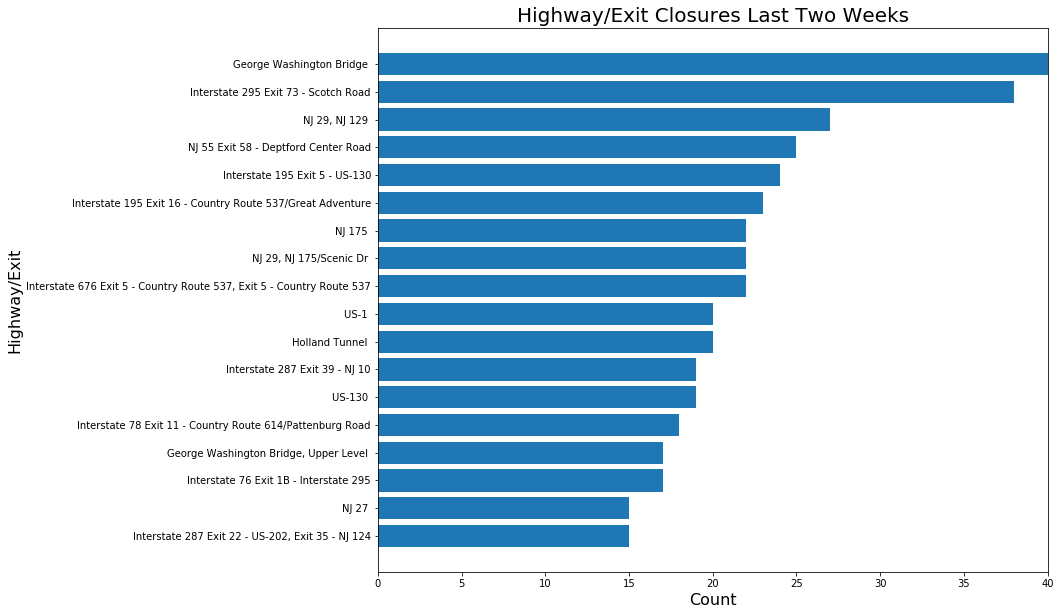

In [28]:
plt.figure(figsize = (12, 10));
plt.barh(high_closures.index, high_closures.values);
plt.title('Highway/Exit Closures Last Two Weeks', size = 20);
plt.xlabel('Count', size = 16);
plt.ylabel('Highway/Exit', size = 16);
plt.xlim([0, 40]);

---